1- Explique, resolva e comente o exemplo 3.2 de nosso livro texto (página 113).


In [15]:
%pip install plotly
import plotly.graph_objects as go


L = 5  

x, y, z = [], [], []
for i in range(-L, L+1):
    for j in range(-L, L+1):
        for k in range(-L, L+1):
            x.append(i)
            y.append(j)
            z.append(k)

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=4,
        color='skyblue',
        opacity=0.8,
    )
)])

fig.update_layout(
    title='Rede Cúbica Simples - Visualização 3D Interativa',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


O exemplo fornecido apresenta um código que tem como objetivo apresentar a estrutura de átomos de uma forma tridimensional. Ele utiliza de três loops aninhados para gerar todos os pontos (i,j,k) de uma rede cúbica simples 3D. O código foi readaptado para apresentar o plot acima, utilizei de pesquisa para reformular o código e conseguir o plot apresentado. Foi utilizada a biblioteca plotly.graph_objects para a geração do gráfico em 3D. O exemplo acima pode ser associado à uma estrutura cristalina, conceito utilizado em estrutura de materiais, voltado para a engenharia ou ciência dos materiais, por exemplo.

Ao passar o mouse sobre um ponto, o gráfico exibe uma caixa de informação que mostra os valores exatos das coordenadas 
(x,y,z) daquele ponto.

Isso permite que você identifique a posição de qualquer átomo na rede.

2- Explique, resolva e comente o exemplo 3.1 de nosso livro texto (página 108).

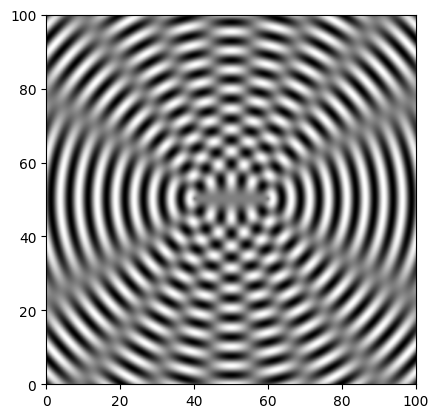

In [16]:
from math import sqrt, sin, pi
from numpy import empty
from pylab import imshow, gray, show

wavelength = 5.0
k = 2 * pi / wavelength
xi0 = 1.0
separation = 20.0  # Separação dos centros em cm
side = 100.0       # Lado do quadrado em cm
points = 500       # Número de pontos da grade em cada lado
spacing = side / points  # Espaçamento dos pontos em cm

# Calcula as posições dos centros dos círculos
x1 = side / 2 + separation / 2
y1 = side / 2
x2 = side / 2 - separation / 2
y2 = side / 2

# Cria um array para armazenar as alturas
xi = empty([points, points], float)

# Calcula os valores no array
for i in range(points):
    y = spacing * i
    for j in range(points):
        x = spacing * j
        r1 = sqrt((x - x1)**2 + (y - y1)**2)
        r2 = sqrt((x - x2)**2 + (y - y2)**2)
        xi[i, j] = xi0 * sin(k * r1) + xi0 * sin(k * r2)

# Cria o gráfico
imshow(xi, origin="lower", extent=[0, side, 0, side])
gray()
show()



Ao jogar duas pedrinhas em um lago, uma em cada lugar diferente. Cada pedrinha faz ondas que se espalham em círculos, subindo e descendo a água enquanto avançam. A altura da água em qualquer ponto depende de como essas ondas chegam, se a onda de uma pedrinha estiver subindo e a da outra também, elas se somam e a água sobe mais, se uma está subindo e a outra descendo, elas podem se cancelar e a água ficar mais baixa. Isso é o que chamamos de interferência.

No exemplo, as ondas têm um tamanho fixo (o comprimento de onda) e uma altura (a amplitude), e as pedrinhas ficam separadas por 20 cm. É calculado, a altura da água numa área grande (1 metro quadrado), dividindo essa área em uma grade bem fina, como se fosse um tabuleiro com muitos pontos. Para cada ponto desse tabuleiro, calculamos a distância até cada pedrinha e usamos uma fórmula que diz a altura da onda nesse ponto, baseada nessa distância.

Depois, somamos as alturas das duas ondas para saber qual é a altura total da água. Fazendo isso para todos os pontos, conseguimos ver no final um desenho que mostra onde as ondas se juntam e formam picos mais altos ou se anulam e a água fica mais calma. Esse desenho mostra as formas que surgem quando duas ondas se encontram e interferem uma com a outra.

<Figure size 1000x500 with 0 Axes>

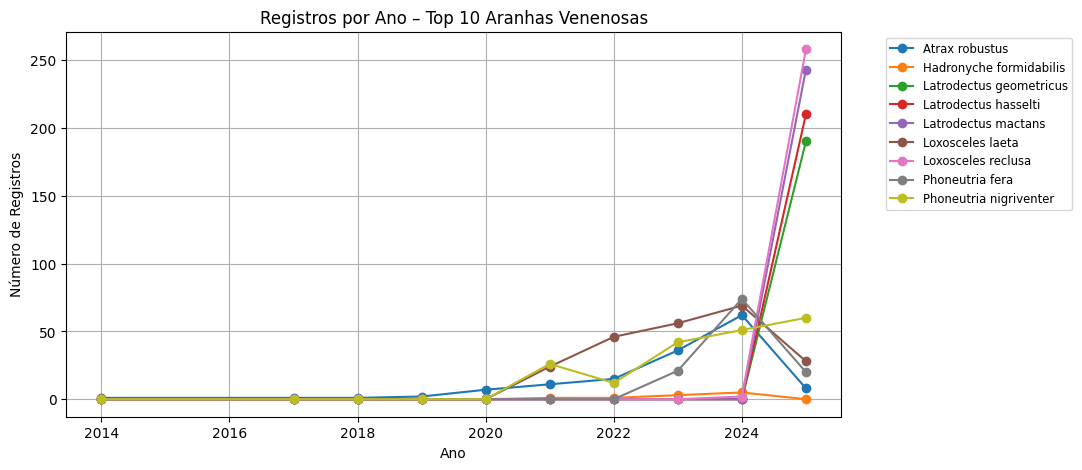

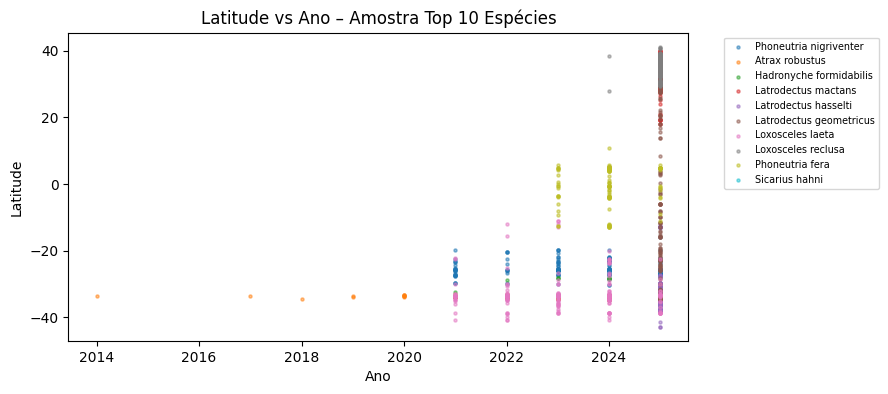

<Figure size 1000x600 with 0 Axes>

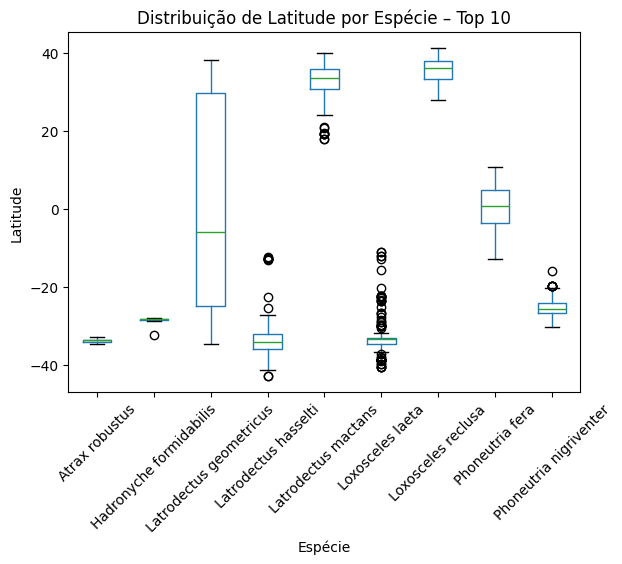

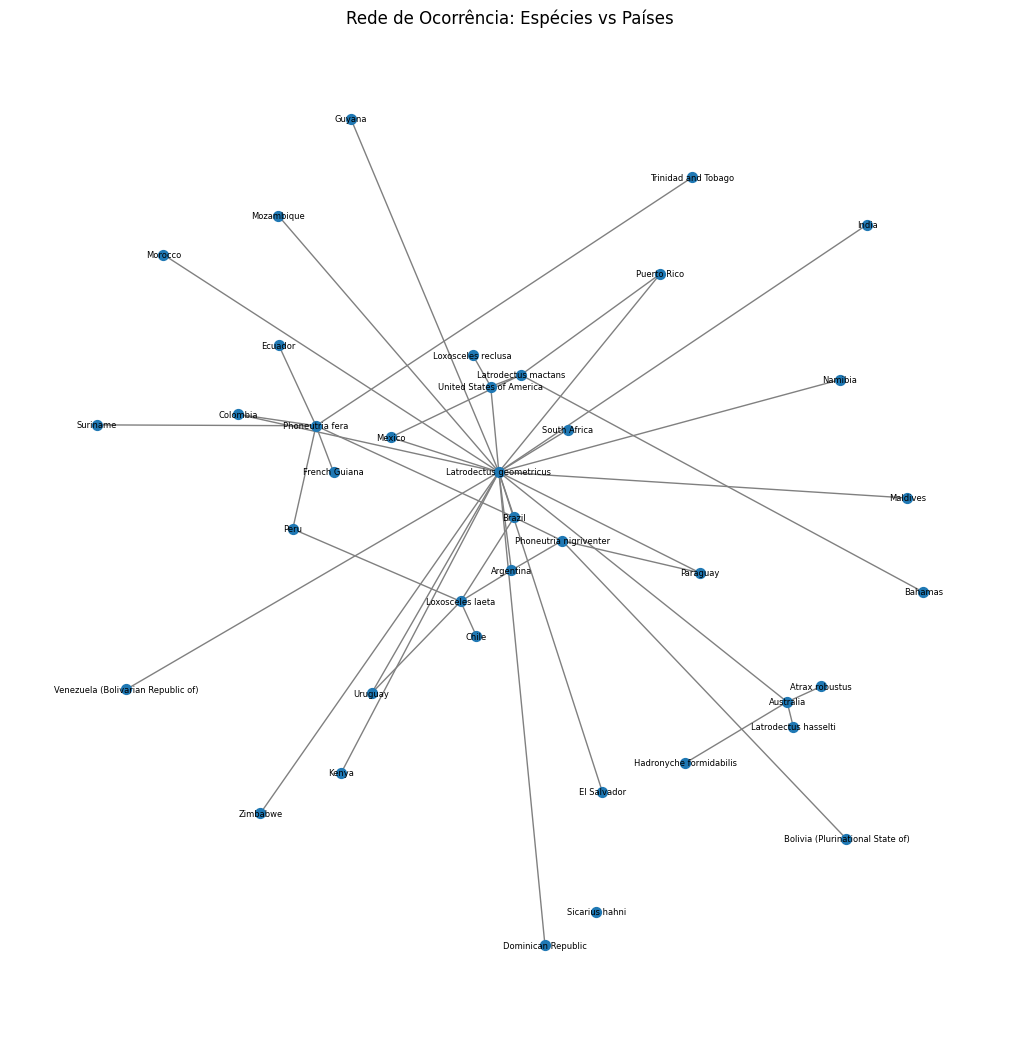

In [12]:
# ─── Instale as dependências ─────────────────────────────────────────────────
# pip install pygbif pandas folium branca matplotlib networkx numpy

from pygbif import occurrences, species
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, HeatMap
from branca.element import IFrame
import networkx as nx
import matplotlib.colors as mcolors

# ─── 1. Defina as Top 10 espécies venenosas ──────────────────────────────────
top_species = [
    'Phoneutria nigriventer',
    'Atrax robustus',
    'Hadronyche formidabilis',
    'Latrodectus mactans',
    'Latrodectus hasselti',
    'Latrodectus geometricus',
    'Loxosceles laeta',
    'Loxosceles reclusa',
    'Phoneutria fera',
    'Sicarius hahni'
]

# ─── 2. Coleta e pré-processamento ────────────────────────────────────────────
dfs = []
max_raw = 5000
for sp in top_species:
    key = species.name_backbone(name=sp, rank='SPECIES')['usageKey']
    res = occurrences.search(taxonKey=key, hasCoordinate=True, limit=max_raw)
    tmp = pd.json_normalize(res['results'])
    tmp['species'] = sp
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)
df = (
    df.dropna(subset=['decimalLatitude','decimalLongitude','eventDate'])
      .assign(eventDate=lambda d: pd.to_datetime(d['eventDate'], errors='coerce'))
      .dropna(subset=['eventDate'])
)
df['year']  = df['eventDate'].dt.year
df['month'] = df['eventDate'].dt.month

# Amostragem para desempenho em mapas e scatter
df_samp = df.sample(min(len(df), 3000), random_state=1)

# ─── 3. Gráficos Estatísticos ────────────────────────────────────────────────
# Série temporal (Registros por ano)
time_df = df.groupby(['year','species']).size().reset_index(name='count')
pivot = time_df.pivot(index='year', columns='species', values='count').fillna(0)
plt.figure(figsize=(10,5))
pivot.plot(marker='o', linewidth=1.5, figsize=(10,5))
plt.title('Registros por Ano – Top 10 Aranhas Venenosas')
plt.xlabel('Ano')
plt.ylabel('Número de Registros')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

# Dispersão (Ano vs Latitude)
plt.figure(figsize=(8,4))
for sp in top_species:
    sub = df_samp[df_samp['species']==sp]
    plt.scatter(sub['year'], sub['decimalLatitude'], s=5, alpha=0.5, label=sp)
plt.title('Latitude vs Ano – Amostra Top 10 Espécies')
plt.xlabel('Ano')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='x-small')
plt.show()

# Distribuição de Latitude por Espécie (Boxplot)
plt.figure(figsize=(10,6))
df_samp.boxplot(column='decimalLatitude', by='species', grid=False, rot=45)
plt.title('Distribuição de Latitude por Espécie – Top 10')
plt.suptitle('')
plt.xlabel('Espécie')
plt.ylabel('Latitude')
plt.show()

# ─── 4. Mapa interativo com ícones (Folium) ─────────────────────────────────
# Usando plt.get_cmap em vez de cm.get_cmap para evitar warning de depreciação
cmap = plt.get_cmap('tab10', len(top_species))
color_map = {sp: mcolors.to_hex(cmap(i)) for i, sp in enumerate(top_species)}

m = folium.Map(location=[0,0], zoom_start=2, tiles='CartoDB positron')
for sp in top_species:
    cluster = MarkerCluster(name=sp).add_to(m)
    subset = df_samp[df_samp['species']==sp]
    for _, row in subset.iterrows():
        data_pt = row.eventDate.strftime('%d/%m/%Y')
        html = f"""
          <div style=\"text-align:center\">
            <b>Espécie:</b> {sp}<br>
            <b>Data:</b> {data_pt}
          </div>
        """
        iframe = IFrame(html, width=140, height=80)
        popup = folium.Popup(iframe, max_width=140)
        # Define cor de fundo padrão válida e usa icon_color para cor customizada
        icon = folium.Icon(
            icon='spider',
            prefix='fa',
            color='red',              # fundo (pinos) em azul, um valor válido
            icon_color='white'   # cor do ícone em hex, sem warning
        )
        folium.Marker(
            location=[row.decimalLatitude, row.decimalLongitude],
            icon=icon,
            popup=popup
        ).add_to(cluster)

# Heatmap de densidade
HeatMap(
    df_samp[['decimalLatitude','decimalLongitude']].values,
    radius=8,
    name='Heatmap'
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
# Exibe o mapa interativo
display(m)

# ─── 5. Rede espécie–país (NetworkX) ────────────────────────────────────────
edge_counts = df.groupby(['species','country']).size().reset_index(name='count')
G = nx.Graph()
for sp in top_species:
    G.add_node(sp, type='species')
for country in edge_counts['country'].unique():
    G.add_node(country, type='country')
for _, row in edge_counts.iterrows():
    if row['count']>0:
        G.add_edge(row['species'], row['country'], weight=row['count'])

pos = nx.spring_layout(G, k=1, seed=42)
plt.figure(figsize=(10,10))
nx.draw(G, pos, with_labels=True, node_size=50, font_size=6, edge_color='gray')
plt.title('Rede de Ocorrência: Espécies vs Países')
plt.axis('off')
plt.show()
